In [4]:
# Import Tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import ds100_utils

# Import Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import warnings
warnings.filterwarnings("ignore")
import zipfile
import os
from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Get Data
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()


Here I'll just be making sure that the data is in the right shape.

I'll be using a simple linear model with Sale Price as our regressand. Lets make sure it is here.



In [5]:

training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
assert training_data.shape == (204792, 62)
assert 'Sale Price' in training_data.columns.values

In [6]:
# For those interested, run the command below. These are going to be the features we have access to select from that are included in the data.
#training_data.columns

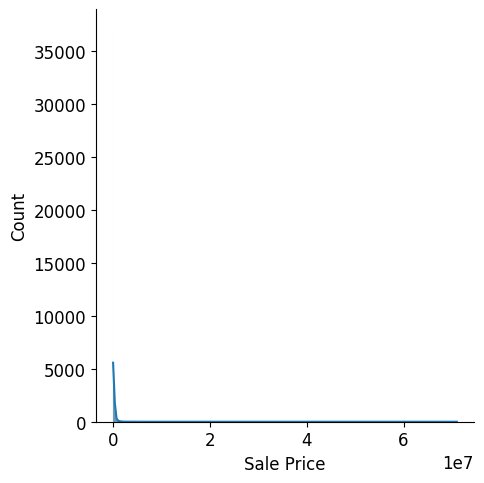

In [7]:
# Next, I'll start my analysis
label='Sale Price'

sns.displot(data=training_data, x=label, kde=True)

Our visualization seems to be ineffective due to some outliers. Lets investigate the spike around zero.

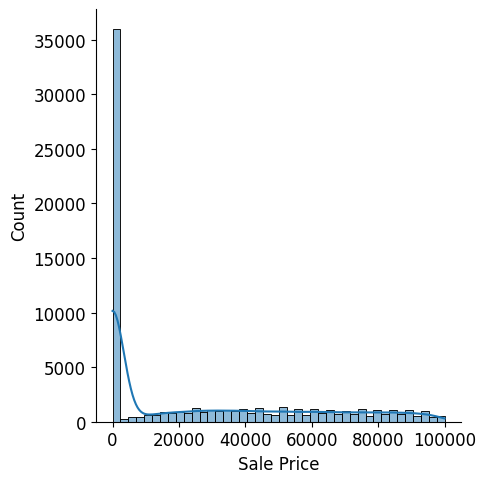

In [8]:
label='Sale Price'
zoom_in = training_data[training_data['Sale Price'] < 100000 ]
sns.displot(data=zoom_in, x=label, kde=True)

(35568, 305, 125)

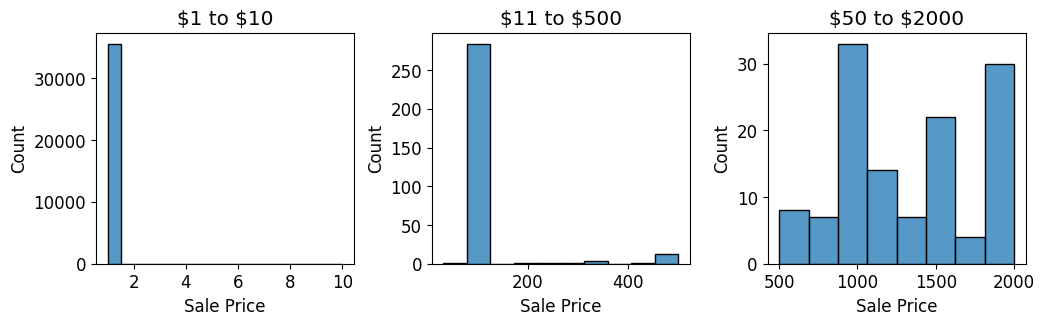

In [9]:
range_1_10 = training_data[training_data['Sale Price'] <= 10]
range_11_500 = training_data[training_data['Sale Price'] > 10][training_data['Sale Price'] <= 500]
range_500_2000 = training_data[training_data['Sale Price'] > 500][training_data['Sale Price'] <= 2000]

def plot_distribution(data1, data2, data3, label):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3),)
    var =2000
    sns.histplot(data1, x=label, ax=axs[0], kde=False).set_title('\$1 to \$10')
    sns.histplot(data2, x=label, ax=axs[1], kde=False).set_title('\$11 to \$500')
    sns.histplot(data3, x=label, ax=axs[2], kde=False).set_title('\$50 to \$2000')

    plt.subplots_adjust(wspace=.3)

plot_distribution(range_1_10,range_11_500,range_500_2000,label)

#Number of observations in each plot.
len(range_1_10), len(range_11_500), len(range_500_2000)

I've rescaled the y-axis so we can see the relative number of houses in each sub-bin. 
Notice that there are 35568 lots that sold for less than 10 dollars (first plot).  
We'll exclude these, and the 305 other lots that sold for less than 500 dollars (second plot). 
These might be inheritences, transfers of property or some other technicality.

The data in the third sub-bin looks much more plain, and also only have 125 observation, so we'll keep it. 

Lets see what our data looks like after removing the first two sub-bins, and applying a log transform to the the remaining data

<AxesSubplot: xlabel='Log Sale Price', ylabel='Density'>

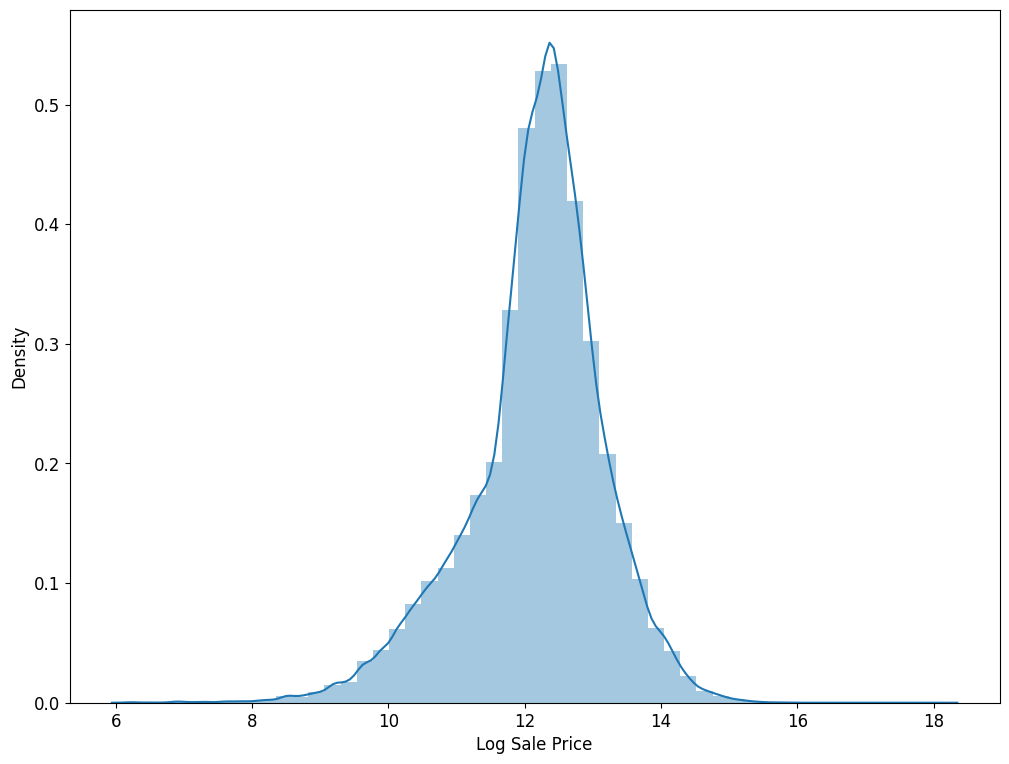

In [10]:
training_data = training_data.loc[training_data['Sale Price'] >= 500, :]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

sns.distplot(training_data['Log Sale Price'])

In [11]:
training_data['Log Sale Price'].describe()

count    168931.000000
mean         12.168227
std           0.999586
min           6.214608
25%          11.703546
50%          12.278393
75%          12.765688
max          18.078190
Name: Log Sale Price, dtype: float64

This data looks far more normal and will be much better for working with.

In the future, we might want a different method to remove outliers.

Outliers are usually categorized as anything (1.5 * IQR) above Q3 or below Q1. The IQR is just the range between the 75th and 25th percentiles.
Let's define a function that will help us remove outliers from any feature. The function will set the exclusion length above Q3 to any Distance*IQR, where Distance is set to a defualt of 1.5

In [12]:
def outlier_remover(data, label, dist=1.5):
    q25 = data[label].quantile(.25)
    q75 = data[label].quantile(.75)
    iqr = q75-q25
    lgth= dist*iqr
    lower = q25-lgth
    upper = q75+lgth
    data = data[data[label] < upper][data[label] > lower]

The first metric most people when thinking of the potential price of a house is most likely the lot size. Let's check the correlation between 'Building Square Feet' and 'Sale Price'. Before we do this though, I'll add a column 'Log Building Square Feet'. We might want to do this more than once, so I'll write a function for it.

In [13]:
def log_adder(data, label):
    string = 'Log ' + label
    data[string] = np.log(training_data[label])

log_adder(training_data, 'Building Square Feet')

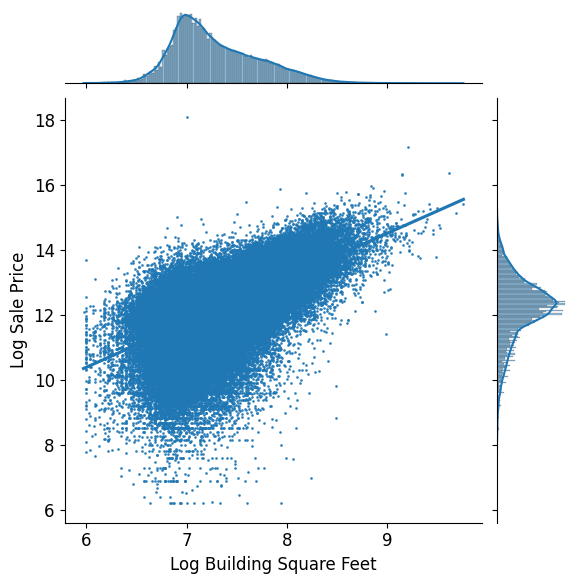

In [14]:
sns.jointplot(training_data, x='Log Building Square Feet', y='Log Sale Price', kind='reg', scatter_kws={'s': 1})

Next, I'll investigate some other parts of the data and see if we can extract more information. Let's pick an arbitrary data point and read its description. 

In [15]:
training_data['Description'][69420]

'This property, sold on 01/05/2016, is a one-story houeshold located at 549 FORSYTHE AVE.It has a total of 5 rooms, 3 of which are bedrooms, and 2.0 of which are bathrooms.'

Our data doesn't have a feature for 'number of bedrooms'. However, this information can be found in the description. Let's extract it.

In [16]:
def add_total_bedrooms(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_rooms = data.copy()
  regex = "rooms, (.*) of which are bedrooms"
  with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(regex).astype(int) 
  return with_rooms

training_data = add_total_bedrooms(training_data)

We can also get the date of the transaction, this might be useful as housing prices tend to go up over long periods of time. 

The regex statemnt used to pull this is: \d{1,2}\/\d{1,2}\/\d{4}

In [17]:
def add_date(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_date = data.copy()
  regex = "(\d{1,2}\/\d{1,2}\/\d{4})"
  with_date['Date'] = with_date['Description'].str.extract(regex)
  return with_date

training_data = add_date(training_data)

Next, we'll get stories. This will be trickier because the data is given as a string, and we can't be sure they follow the same format.

In [18]:
def add_stories(data):
  """
  Input:
    data (data frame): a data frame containing at least the Description column.
  """
  with_stories = data.copy()
  regex = "is a\s(\w+)"
  with_stories['Stories'] = with_stories['Description'].str.extract(regex)
  return with_stories

training_data = add_stories(training_data)

In [19]:
training_data.Stories.unique()

array(['one', 'two', 'three', 'split'], dtype=object)

What is a split-story house?

In [20]:
training_data[training_data['Stories'] == 'split']['Stories']

training_data['Description'][9120]

'This property, sold on 05/04/2017, is a split-level houeshold located at 1517 ALIMA TER.It has a total of 6 rooms, 4 of which are bedrooms, and 1.0 of which are bathrooms.'

According to the internet:


[<img src="screenshot.png" width="500"/>](screenshot.png)


I'm still not really sure how I should treat stories. Without the split, I could simply numerically encode 'one' 'two or 'three' but 'split' homes make our data more categorical than I would feel comfortable with. 

<AxesSubplot: xlabel='Stories', ylabel='Sale Price'>

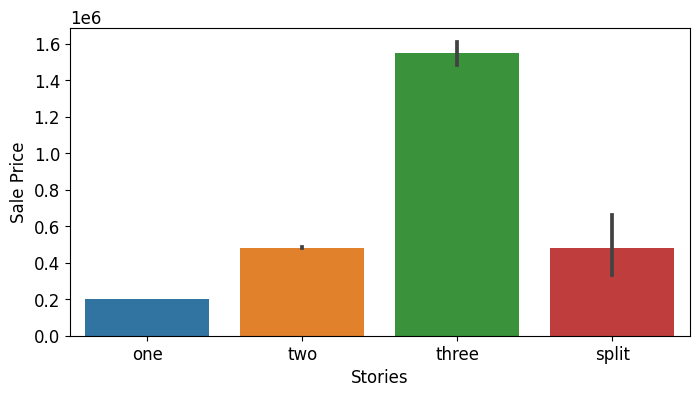

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(data=training_data, x='Stories', y='Sale Price', ax=ax)

I could *naively* use numerical values and encode 'split' as two here. I'll add it to the array, but we can decide if we want to use this later.

In [43]:
mapping = {
  'one': 1,
  'two': 2,
  'split': 2,
  'three': 3
}

training_data['Number Stories'] = training_data['Stories'].map(mapping)
training_data.loc[:,['Stories', 'Number Stories']]

,Stories,Number Stories
1,one,1
2,one,1
3,one,1
4,one,1
6,one,1
...,...,...
204787,one,1
204788,one,1
204789,one,1
204790,one,1


A 3-story property is probably more likely to be an aprtment complex. There exists a feature called apartments, which ranges from 0 to 6, excluding 1. I'll add a new binary column which specifies if it is an apartment complex or not. If it has zero apartments, it is single family, if it has 2 or more, it is an apartment.

In [118]:
training_data['Binary Apt'] = training_data['Apartments'].apply(lambda x: 0 if x in [0, 1] else 1)

training_data[training_data['Apartments'] ==5]

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,Date,Stories,Number Stories,Binary Apt
33582,13162030110000,203,60,2825.000000,71,5.0,1.0,1.0,1.0,3.0,...,7160,"This property, sold on 06/06/2018, is a one-st...",2825.000000,12.323856,7.060476,3,06/06/2018,one,1,1
36240,25284170030000,203,250,3577.341533,70,5.0,2.0,1.0,1.0,3.0,...,70250,"This property, sold on 09/05/2013, is a one-st...",3577.341533,9.517825,7.130899,3,09/05/2013,one,1,1
49321,15123200140000,206,40,7425.000000,33,5.0,1.0,1.0,1.0,3.0,...,3340,"This property, sold on 05/18/2018, is a two-st...",7425.000000,12.992255,7.779885,3,05/18/2018,two,2,1
78555,16314220110000,205,70,3488.376096,11,5.0,1.0,1.0,2.0,3.0,...,1170,"This property, sold on 10/30/2013, is a one-st...",3488.376096,9.567665,6.313548,2,10/30/2013,one,1,1
83035,26062230130000,202,100,450.398804,70,5.0,1.0,1.0,2.0,3.0,...,70100,"This property, sold on 05/19/2016, is a one-st...",450.398804,8.958926,6.253829,2,05/19/2016,one,1,1
89666,16314220110000,205,70,3488.376096,11,5.0,1.0,1.0,2.0,3.0,...,1170,"This property, sold on 07/16/2013, is a one-st...",3488.376096,9.597981,6.313548,2,07/16/2013,one,1,1
134622,13301350350000,203,200,7308.000000,71,5.0,1.0,1.0,4.0,3.0,...,71200,"This property, sold on 06/11/2018, is a one-st...",7308.000000,12.524526,7.368340,4,06/11/2018,one,1,1


In [ ]:
import statsmodels.formula.api as smf
results = smf.ols('y ~ x1 + age', data=df).fit()
print(results.summary())

results_2 = smf.ols('y ~ x1 + age + C(ethnicity) + C(gender)', data=df).fit()
print(results_2.summary())
